#Benchmarking Regularized Regression Solvers: ISTA, FISTA, Dual-FISTA, and Gradient Descent



In [55]:
!pip install memory_profiler
!pip install seaborn

import numpy as np
import time
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import memory_profiler
from memory_profiler import memory_usage
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

##########################################################################PROXIMITY OPERATORS################################################

def soft_threshold(x, lambda_val):
    """
    Proximal operator for the L1 norm (soft-thresholding function).

    This function applies soft-thresholding to each component of x:
        prox_{λ||·||₁}(x) = sign(x) * max(|x| - λ, 0)

    Parameters:
    - x : ndarray, input vector
    - lambda_val : float, thresholding parameter

    Returns:
    - Thresholded vector (same shape as x)
    """
    return np.sign(x) * np.maximum(np.abs(x) - lambda_val, 0)


def elastic_net_prox(x, lambda_l1, lambda_l2, L):
    """
    Proximal operator for the elastic net regularization (L1 + L2).

    This combines the L1 (via soft-thresholding) and L2 (via shrinkage) penalties:
        prox(x) = soft_threshold(x, λ₁ / L) / (1 + λ₂ / L)

    Parameters:
    - x : ndarray, input vector
    - lambda_l1 : float, L1 regularization parameter
    - lambda_l2 : float, L2 regularization parameter
    - L : float, step size denominator (e.g., Lipschitz constant)

    Returns:
    - Vector after applying the elastic net proximal operator
    """
    return soft_threshold(x, lambda_l1 / L) / (1 + lambda_l2 / L)


def ridge_prox(x, lambda_l2, L):
    """
    Proximal operator for the L2 norm (ridge regression).

    For the squared L2 penalty, the proximal operator is simply:
        prox(x) = x / (1 + λ₂ / L)

    Parameters:
    - x : ndarray, input vector
    - lambda_l2 : float, L2 regularization parameter
    - L : float, step size denominator (e.g., Lipschitz constant)

    Returns:
    - Shrunk vector (same shape as x)
    """
    return x / (1 + lambda_l2 / L)


def prox_operator(x, regularization_type, lambda_l1, lambda_l2, L):
    """
    Applies the right proximal operator based on the chosen regularization type.

    This function is a simple dispatcher: depending on whether you're using L1, L2, or
    elastic net regularization, it calls the corresponding proximal function:

    - 'l1' → applies soft-thresholding (makes the vector sparse by shrinking small values to zero)
    - 'l2' → applies ridge shrinkage (scales down the entire vector)
    - 'elastic_net' → combines both effects: soft-thresholding + shrinkage

    Parameters:
    - x : the input vector (usually model coefficients)
    - regularization_type : string, one of {'l1', 'l2', 'elastic_net'}
    - lambda_l1 : L1 regularization parameter
    - lambda_l2 : L2 regularization parameter
    - L : step size denominator (often the Lipschitz constant of the gradient)

    Returns:
    - The updated vector after applying the selected proximal operator

    Raises:
    - ValueError if the regularization type is not recognized
    """
    if regularization_type == 'l1':
        return soft_threshold(x, lambda_l1 / L)
    elif regularization_type == 'l2':
        return ridge_prox(x, lambda_l2, L)
    elif regularization_type == 'elastic_net':
        return elastic_net_prox(x, lambda_l1, lambda_l2, L)
    else:
        raise ValueError(f"Unknown regularization type: {regularization_type}")


######################################################LINE SEARCH METHODS###########################################################
def determine_reg_type(lambda_l1, lambda_l2):
    """
    Determines which type of regularization is being used based on the values
    of lambda_l1 and lambda_l2.

    This helper function is used to automatically select the correct regularization
    label ('l1', 'l2', or 'elastic_net') depending on which regularization parameters
    are active.

    Parameters:
    - lambda_l1 : float, L1 regularization strength
    - lambda_l2 : float, L2 regularization strength

    Returns:
    - A string: 'l1', 'l2', or 'elastic_net' depending on the combination

    Notes:
    - If both lambda_l1 and lambda_l2 are > 0, it assumes elastic net.
    - If only one is > 0, it selects the corresponding type.
    - If both are 0 or missing, the function returns None (implicitly).
    """
    if lambda_l1 > 0 and lambda_l2 > 0:
        return 'elastic_net'
    elif lambda_l1 > 0:
        return 'l1'
    elif lambda_l2 > 0:
        return 'l2'

## Objective function

def objective_function(A, b, x, lambda_l1=0.0, lambda_l2=0.0, regularization_type='l1'):
    """
    Computes the value of the regularized objective function:
        0.5 * ||Ax - b||² + regularization term

    Parameters:
    - A : design matrix
    - b : target vector
    - x : current solution vector
    - lambda_l1 : L1 regularization coefficient
    - lambda_l2 : L2 regularization coefficient
    - regularization_type : 'l1', 'l2', or 'elastic_net'

    Returns:
    - The scalar value of the objective function
    """
    # Data fitting term (squared error)
    f_x = 0.5 * np.sum((A @ x - b) ** 2)

    # Regularization term depending on type
    if regularization_type == 'l1':
        g_x = lambda_l1 * np.sum(np.abs(x))
    elif regularization_type == 'l2':
        g_x = 0.5 * lambda_l2 * np.sum(x ** 2)
    elif regularization_type == 'elastic_net':
        g_x = lambda_l1 * np.sum(np.abs(x)) + 0.5 * lambda_l2 * np.sum(x ** 2)
    else:
        raise ValueError(f"Unknown regularization type: {regularization_type}")

    return f_x + g_x


def backtracking_line_search(A, b, x, grad, lambda_l1, lambda_l2, regularization_type, alpha=0.5, beta=0.8, max_iter=100):
    """
    Performs backtracking line search to find a suitable step size t.

    Parameters:
    - A, b : dataset (design matrix and target vector)
    - x : current solution
    - grad : gradient at current x
    - lambda_l1, lambda_l2 : regularization parameters
    - regularization_type : type of regularization ('l1', 'l2', 'elastic_net')
    - alpha, beta : backtracking parameters (0 < beta < 1, alpha typically small)
    - max_iter : max number of reductions before giving up

    Returns:
    - t : step size that satisfies the backtracking condition
    """
    t = 1.0  # initial step size
    f_x = objective_function(A, b, x, lambda_l1, lambda_l2, regularization_type)
    grad_norm_sq = np.sum(grad ** 2)

    for _ in range(max_iter):
        # Compute the new point using the proximal operator
        x_new = prox_operator(x - t * grad, regularization_type, lambda_l1, lambda_l2, 1 / t)
        f_x_new = objective_function(A, b, x_new, lambda_l1, lambda_l2, regularization_type)

        # Check Armijo condition (sufficient decrease)
        if f_x_new <= f_x - alpha * t * grad_norm_sq:
            return t
        t *= beta  # Reduce step size

    return t  # Return final t even if condition wasn't met


############################################################ALGORITHMS###############################################################
## These fonctions are describe in a broad sense in the comments, check the report for clear explanation

def ista(A, b, lambda_l1, lambda_l2=0.0, max_iter=1000, tol=1e-6, regularization_type='elastic_net', line_search='fixed'):
    """
    ISTA (Iterative Soft-Thresholding Algorithm)
    Parameters:
    - A : ndarray of shape (n_samples, n_features), design matrix
    - b : ndarray of shape (n_samples,), target values
    - lambda_l1 : float, L1 regularization coefficient
    - lambda_l2 : float, L2 regularization coefficient (default: 0.0)
    - max_iter : int, maximum number of iterations (default: 1000)
    - tol : float, stopping criterion on the L2 norm of update difference (default: 1e-6)
    - regularization_type : str, one of {'l1', 'l2', 'elastic_net'}
    - line_search : str, either 'fixed' or 'backtracking'

    Returns:
    - x : estimated coefficients (solution)
    - k : number of iterations
    - mse_history : list of mean squared errors over iterations
    - f_x_history : list of objective function values over iterations
    """

    # Initialize solution vector to zeros
    n_samples, n_features = A.shape
    x = np.zeros(n_features)

    # Compute Lipschitz constant L if using fixed step size
    if line_search == 'fixed':
        L = np.linalg.norm(A.T @ A, 2) + 2 * lambda_l2  # accounts for L2 regularization

    # Lists to store performance metrics if needed
    mse_history = []
    f_x_history = []

    # Main optimization loop
    for k in range(max_iter):
        # Compute the gradient of the smooth part (squared loss + L2)
        grad = A.T @ (A @ x - b) + 2 * lambda_l2 * x

        # Apply one ISTA update step depending on line search method
        if line_search == 'fixed':
            x_new = prox_operator(x - grad / L, regularization_type, lambda_l1, lambda_l2, L)
        elif line_search == 'backtracking':
            t = backtracking_line_search(A, b, x, grad, lambda_l1, lambda_l2, regularization_type)
            x_new = prox_operator(x - t * grad, regularization_type, lambda_l1, lambda_l2, 1 / t)
        else:
            raise ValueError(f"Unknown line search method: {line_search}")

        # Save MSE and objective value every 10 iterations or at the end
        if k % 10 == 0 or k == max_iter - 1:
                mse = np.mean((A @ x_new - b) ** 2)
                f_x = objective_function(A, b, x_new, lambda_l1, lambda_l2, regularization_type)
                mse_history.append(mse)
                f_x_history.append(f_x)

        # Check for convergence based on L2 norm of change
        if np.linalg.norm(x_new - x) < tol:
            break

        # Update solution
        x = x_new

    # Return final solution and the lists
    return x, k,mse_history, f_x_history


def fista(A, b, lambda_l1, lambda_l2=0.0, max_iter=1000, tol=1e-6, regularization_type='elastic_net', line_search='fixed'):
    """
    FISTA (Fast Iterative Shrinkage-Thresholding Algorithm)
    Parameters:
    - A: ndarray of shape (n_samples, n_features), the design matrix
    - b: ndarray of shape (n_samples,), the target vector
    - lambda_l1: float, L1 regularization parameter
    - lambda_l2: float, L2 regularization parameter (default: 0.0)
    - max_iter: int, maximum number of iterations (default: 1000)
    - tol: float, tolerance for convergence (default: 1e-6)
    - regularization_type: str, one of {'l1', 'l2', 'elastic_net'}
    - line_search: str, either 'fixed' or 'backtracking'

    Returns:
    - x: estimated regression coefficients
    - (optional) k: number of iterations run
    - (optional) mse_history: list of MSE values during iterations
    - (optional) f_x_history: list of objective values during iterations
    """

    # Initialization of variables
    n_samples, n_features = A.shape
    x = np.zeros(n_features)  # Initial guess for solution
    y = x.copy()              # Momentum variable for FISTA
    t = 1                    # Initial FISTA acceleration parameter

    # Estimate Lipschitz constant L of the gradient (for fixed step size)
    if line_search == 'fixed':
        L = np.linalg.norm(A.T @ A, 2) + 2 * lambda_l2

    # Initialize history containers if needed
    mse_history = []
    f_x_history = []

    # Main iteration loop
    for k in range(max_iter):
        # Compute gradient of the smooth part (squared loss + L2 if present)
        grad = A.T @ (A @ y - b) + 2 * lambda_l2 * y

        # Update rule depending on line search strategy
        if line_search == 'fixed':
            # Fixed step size update with proximity operator
            x_new = prox_operator(y - grad / L, regularization_type, lambda_l1, lambda_l2, L)
        elif line_search == 'backtracking':
            # Adaptive step size via backtracking
            t_step = backtracking_line_search(A, b, y, grad, lambda_l1, lambda_l2, regularization_type)
            x_new = prox_operator(y - t_step * grad, regularization_type, lambda_l1, lambda_l2, 1 / t_step)
        else:
            raise ValueError(f"Unknown line search method: {line_search}")

        # FISTA acceleration step: compute new momentum
        t_new = (1 + np.sqrt(1 + 4 * t**2)) / 2
        y = x_new + ((t - 1) / t_new) * (x_new - x)

        # Optionally track MSE and objective function every 10 steps
        if k % 10 == 0 or k == max_iter - 1:
                mse = np.mean((A @ x_new - b) ** 2)
                mse_history.append(mse)
                f_x = objective_function(A, b, x_new, lambda_l1, lambda_l2, regularization_type)
                f_x_history.append(f_x)

        # Check for convergence (based on change in x)
        if np.linalg.norm(x_new - x) < tol:
            break

        # Prepare for next iteration
        x, t = x_new, t_new

    # Return solution and the lists
    return x, k, mse_history, f_x_history



def gradient_descent(A, b, lambda_l2=0.0, max_iter=1000, tol=1e-6, line_search='fixed'):
    """
    Gradient Descent algorithm ( solves L2 only)

    Parameters:
    - A : ndarray, shape (n_samples, n_features), design matrix
    - b : ndarray, shape (n_samples,), target vector
    - lambda_l2 : float, L2 regularization parameter (default: 0.0)
    - max_iter : int, maximum number of iterations (default: 1000)
    - tol : float, stopping criterion on the L2 norm of the update difference (default: 1e-6)
    - line_search : str, either 'fixed' (default) or 'backtracking' for step size selection

    Returns:
    - x : estimated coefficients (solution)
    - (optional) k : number of iterations
    - (optional) mse_history : list of mean squared errors over iterations
    - (optional) f_x_history : list of objective function values over iterations
    """

    # Initialization
    n_features = A.shape[1]
    x = np.zeros(n_features)  # Start with zero vector

    mse_history = []
    f_x_history = []

    # Compute fixed learning rate if applicable
    if line_search == 'fixed':
        L = np.linalg.norm(A.T @ A, 2) + 2 * lambda_l2  # Lipschitz constant with L2 term
        lr = 1 / L  # Fixed step size

    # Main gradient descent loop
    for k in range(int(max_iter)):
        # Compute gradient of the smooth objective
        grad = A.T @ (A @ x - b) + 2 * lambda_l2 * x

        # Update rule based on chosen line search method
        if line_search == 'fixed':
            x_new = x - lr * grad
        elif line_search == 'backtracking':
            # Use adaptive step size via backtracking
            t = backtracking_line_search(A, b, x, grad, 0.0, lambda_l2, 'l2')
            x_new = x - t * grad
        else:
            raise ValueError(f"Unknown line search method: {line_search}")

        # Track MSE and objective every 10 iterations (or at the last one)
        if k % 10 == 0 or k == max_iter - 1:
                mse = np.mean((A @ x_new - b) ** 2)
                mse_history.append(mse)
                f_x = objective_function(A, b, x_new, lambda_l2, 0, regularization_type=determine_reg_type(0, lambda_l2))
                f_x_history.append(f_x)

        # Check for convergence (small change in x)
        if np.linalg.norm(x_new - x) < tol:
            break

        # Update solution
        x = x_new

    # Return solution and the lists
    return x, k, mse_history, f_x_history


def dual_fista(A, b, lambda_l1, max_iter=1000, tol=1e-6):
    """
    Dual-FISTA solver (solves L1 only).

    Parameters:
    - A : ndarray of shape (n_samples, n_features), design matrix
    - b : ndarray of shape (n_samples,), target vector
    - lambda_l1 : float, L1 regularization coefficient
    - max_iter : int, maximum number of iterations (default: 1000)
    - tol : float, stopping criterion based on gradient norm (default: 1e-6)

    Returns:
    - x_est : estimated primal solution vector
    - (optional) k : number of iterations executed
    - (optional) mse_history : list of mean squared errors over iterations
    - (optional) f_x_history : list of primal objective function values
    """

    # Initialization of dual variables
    n_samples, n_features = A.shape
    alpha = np.zeros(n_samples)  # Dual variable
    y = alpha.copy()             # Momentum variable for FISTA
    t = 1.0                      # Acceleration parameter

    # Lipschitz constant of the dual gradient
    L = np.linalg.norm(A @ A.T, 2)

    mse_history = []
    f_x_history = []

    # Main optimization loop in the dual space
    for k in range(max_iter):
        # Compute gradient of the dual objective
        grad = A @ (A.T @ y) - b

        # Gradient step in the dual space
        alpha_new = y - grad / L

        # Project onto the dual set
        AT_alpha = A.T @ alpha_new
        scaling = max(1.0, np.max(np.abs(AT_alpha)) / lambda_l1)
        alpha_new /= scaling

        # FISTA acceleration update
        t_new = (1 + np.sqrt(1 + 4 * t**2)) / 2
        y = alpha_new + ((t - 1) / t_new) * (alpha_new - alpha)

        # Update dual variables for next iteration
        alpha = alpha_new
        t = t_new

        # Recover primal variable from dual (estimate)
        x_est = A.T @ alpha

        # Optionally track MSE and objective value every 10 iterations
        if k % 10 == 0 or k == max_iter - 1:
                # Mean squared error on primal solution
                mse = np.mean((A @ x_est - b) ** 2)
                mse_history.append(mse)

                # Primal objective value (f(x))
                f_x = 0.5 * np.linalg.norm(A @ x_est - b) ** 2 + lambda_l1 * np.linalg.norm(x_est, 1)
                f_x_history.append(f_x)

        # Stopping condition: gradient in the dual is small enough
        if np.linalg.norm(grad) < tol:
            break

    # Return results and the lists
    return x_est, k, mse_history, f_x_history


In [56]:
# Synthetic data generation for testing purposes
# Used in the test phase of the project since we have real datasets this function is effectively useless
def generate_data(n_samples=200, n_features=50, sparsity=0.1, noise_level=0.1):
    np.random.seed(42)
    A = np.random.randn(n_samples, n_features)
    x_true = np.zeros(n_features)
    n_nonzero = int(sparsity * n_features)
    nonzero_indices = np.random.choice(n_features, n_nonzero, replace=False)
    x_true[nonzero_indices] = np.random.randn(n_nonzero)
    b = A @ x_true + noise_level * np.random.randn(n_samples)
    return A, b, x_true

In [57]:
######################################################## BENCHMARKING ##############################################################

def run_benchmark(algorithms, data_configs, lambda_range_l1, lambda_range_l2, max_iter=1000, tol=1e-3,
                   line_search='fixed', n_runs=1,real_datasets=None, target_cols=None):
    """
    Benchmark multiple optimization algorithms across different datasets and regularization parameters.

    This function runs the specified algorithms over a grid of (lambda_l1, lambda_l2) parameters,
    on either synthetic or real datasets. It measures performance in terms of time, memory, iterations,
    MSE, objective function, and solution sparsity.

    Parameters:
    - algorithms : list of algorithm names as strings (must match implemented function names)
    - data_configs : list of dicts with synthetic dataset generation parameters (ignored if using real datasets)
    - lambda_range_l1 : list of L1 regularization values to test
    - lambda_range_l2 : list of L2 regularization values to test
    - max_iter : max number of iterations per run
    - tol : tolerance for convergence
    - line_search : line search method ('fixed' or 'backtracking')
    - n_runs : number of repeated runs per parameter combination
    - real_datasets : dict of real datasets as pandas DataFrames
    - target_cols : dict mapping dataset names to target column names

    Returns:
    - results : pandas DataFrame containing aggregated performance metrics
    - records : list of per-run metrics (MSE and f(x) history)
    """

    if lambda_range_l2 is None:
        lambda_range_l2 = [0.0]

    results = []  # Will store final benchmarking stats
    records = []  # Will store detailed per-iteration history

    # Handle real datasets
    if real_datasets:
        if target_cols is None:
            raise ValueError("target_cols must be specified when using real_datasets.")
        dataset_iter = []
        for name, df in real_datasets.items():
            if name not in target_cols:
                raise ValueError(f"Missing target column for dataset '{name}' in target_cols.")
            target_col = target_cols[name]

            # Extract input features and target
            A = df.drop(columns=[target_col]).values
            b = np.log1p(df[target_col].values)  # Apply log transform to stabilize scale

            # Train/test split and normalization
            A_train, A_test, b_train, b_test = train_test_split(A, b, test_size=0.2, random_state=42)
            scaler_y = MinMaxScaler()
            b_train = scaler_y.fit_transform(b_train.reshape(-1, 1)).ravel()
            b_test  = scaler_y.transform(b_test.reshape(-1, 1)).ravel()

            dataset_iter.append((name, A_train, b_train, A_test, b_test, None))
    else:
        # Generate synthetic datasets from given configurations
        dataset_iter = []
        for i, config in enumerate(data_configs):
            A, b, x_true = generate_data(**config)
            dataset_iter.append((f"synthetic_{i}", A, b, None, None, x_true))

    # Loop over datasets and hyperparameters
    for dataset in dataset_iter:
        dataset_name, A, b, A_test, b_test, x_true = dataset

        for lambda_l1 in lambda_range_l1:
            for lambda_l2 in lambda_range_l2:
                # Determine the type of regularization
                reg_type = determine_reg_type(lambda_l1, lambda_l2)

                for algo_name in algorithms:
                    algo_func = globals()[algo_name]  # Retrieve function by name
                    exec_times = []
                    iterations = []
                    memories = []
                    solutions = []
                    last_mse_hist = []

                    # Repeat n_runs to average results
                    for _ in range(n_runs):
                        start_time = time.time()

                        # Run algorithm with memory profiling
                        if algo_name in ['ista', 'fista']:
                            mem_usage = memory_usage((algo_func, (A, b, lambda_l1), {'lambda_l2': lambda_l2,'max_iter': max_iter,'tol': tol,
                                'regularization_type': reg_type,
                                'line_search': line_search
                            }), interval=0.1, timeout=1)
                            x, iters, mse_hist ,f_x_hist = algo_func(A, b, lambda_l1, lambda_l2, max_iter, tol,reg_type, line_search)

                        elif algo_name == 'dual_fista':
                            mem_usage = memory_usage((algo_func, (A, b, lambda_l1), {'max_iter': max_iter,'tol': tol,}), interval=0.1, timeout=1)
                            x, iters, mse_hist, f_x_hist = algo_func(A, b, lambda_l1, max_iter, tol)

                        elif algo_name == 'gradient_descent':
                            mem_usage = memory_usage((algo_func, (A, b), {'lambda_l2': lambda_l2,'max_iter': max_iter,'tol': tol,'line_search': line_search}), interval=0.1, timeout=1)
                            x, iters, mse_hist, f_x_hist = algo_func(A, b, lambda_l2=lambda_l2, max_iter=max_iter,
                                                                     tol=tol,line_search=line_search)

                        end_time = time.time()

                        # Record metrics for this run
                        exec_times.append(end_time - start_time)
                        iterations.append(iters)
                        memories.append(max(mem_usage))
                        solutions.append(x)
                        last_mse_hist = mse_hist
                        last_fx_hist = f_x_hist

                    # Evaluate average performance
                    avg_solution = np.mean(solutions, axis=0)
                    mse_train = np.mean((A @ avg_solution - b) ** 2)
                    mse_test = np.mean((A_test @ avg_solution - b_test) ** 2) if A_test is not None else np.nan
                    sparsity = np.mean(np.abs(avg_solution) < tol)
                    error_to_true = np.nan
                    if real_datasets is None:
                        error_to_true = np.linalg.norm(avg_solution - x_true)

                    results.append({
                        'dataset': dataset_name,
                        'algorithm': algo_name,
                        'lambda_l1': lambda_l1,
                        'lambda_l2': lambda_l2,
                        'n_samples': A.shape[0],
                        'n_features': A.shape[1],
                        'sparsity': sparsity,
                        'avg_time': np.mean(exec_times),
                        'min_time': np.min(exec_times),
                        'max_time': np.max(exec_times),
                        'max_iterations': np.nanmax(iterations),
                        'min_iterations': np.nanmin(iterations),
                        'avg_iterations': np.nanmean(iterations),
                        'avg_memory': np.mean(memories),
                        'mse_train': mse_train,
                        'mse_test': mse_test,
                        'solution_sparsity': sparsity,
                        'error_to_true': error_to_true
                    })

                    # Save MSE and objective history for plotting
                    records.append({
                            'algorithm': algo_name,
                            'dataset': dataset_name,
                            'lambda_l1': lambda_l1,
                            'lambda_l2': lambda_l2,
                            'mse_history': last_mse_hist,
                            'f_x_history': last_fx_hist
                        })

    return pd.DataFrame(results), records


In [58]:
## Was coded on google collab, so we need to connect to the drive to load the preprocessed datasets
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [59]:
## Imports the 3 datasets and creates the target columns
real_datasets = {
    "house_prices": pd.read_csv("/content/drive/MyDrive/house_prices_preprocessed.csv"),
    "house_prices2": pd.read_csv("/content/drive/MyDrive/house2_prices_preprocessed.csv"),
    "Student_grades" : pd.read_csv("/content/drive/MyDrive/students_normalized2.csv")
}
target_cols = {
    "house_prices": "SalePrice",
    "house_prices2": "median_house_value",
    "Student_grades" : "math score"
}

In [60]:
real_datasets["house_prices"].head(5)

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,SalePrice
0,0.131067,-0.237456,-0.333244,0.652644,-0.564161,1.053246,0.878668,0.795643,0.614224,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,208500
1,-0.935733,0.633321,-0.013189,-0.073068,2.030907,0.156179,-0.429577,-0.667353,1.242296,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,181500
2,0.131067,-0.063300,0.446022,0.652644,-0.564161,0.986797,0.830215,0.541858,0.106224,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,223500
3,0.397766,-0.527714,-0.027104,0.652644,-0.564161,-1.870528,-0.720298,-0.667353,-0.517230,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,140000
4,0.131067,0.865528,1.283733,1.378355,-0.564161,0.953572,0.733308,1.945140,0.496460,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,250000


In [61]:
real_datasets["house_prices2"].head(5)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN,median_house_value
0,-1.327835,1.052548,0.982143,-1.117285,-1.309916,-1.325821,-1.291972,2.541006,0.0,0.0,0.0,1.0,0.0,452600.0
1,-1.322844,1.043185,-0.607019,2.329936,2.128690,1.389936,2.348314,2.541006,0.0,0.0,0.0,1.0,0.0,358500.0
2,-1.332827,1.038503,1.856182,-0.697327,-1.095223,-1.098528,-1.099883,2.085156,0.0,0.0,0.0,1.0,0.0,352100.0
3,-1.337818,1.038503,1.856182,-0.835405,-0.936843,-1.017539,-0.941691,1.111288,0.0,0.0,0.0,1.0,0.0,341300.0
4,-1.337818,1.038503,1.856182,-0.582857,-0.778463,-1.008395,-0.791033,0.027262,0.0,0.0,0.0,1.0,0.0,342200.0


In [62]:
real_datasets["Student_grades"].head(5)

,reading score,writing score,gender_male,race/ethnicity_group B,race/ethnicity_group C,race/ethnicity_group D,race/ethnicity_group E,parental level of education_bachelor's degree,parental level of education_high school,parental level of education_master's degree,parental level of education_some college,parental level of education_some high school,lunch_standard,test preparation course_none,math score
0,0.662651,0.711111,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.72
1,0.879518,0.866667,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.69
2,0.939759,0.922222,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.90
3,0.481928,0.377778,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.47
4,0.734940,0.722222,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.76


In [63]:
def get_best_hyperparams(results_df, metric="mse_test"):
    """
    Extract the best (lambda_l1, lambda_l2) combination for each algorithm and dataset
    based on the lowest mse_test (or another metric).

    Parameters:
    - results_df: DataFrame returned by run_benchmark
    - metric: the metric to minimize (default: mse_test)

    Returns:
    - DataFrame with one row per (algorithm, dataset) with the best hyperparameters
    """
    # Filter out NaNs just in case
    filtered_df = results_df.dropna(subset=[metric])

    # Group by algorithm and dataset, select the row with minimal metric value
    best_params = (
        filtered_df.loc[filtered_df.groupby(["algorithm", "dataset"])[metric].idxmin()]
        .reset_index(drop=True)
        .sort_values(by=["dataset", "algorithm"])
    )

    return best_params


In [64]:
## The grids on which the algortihms will be tested
range_l1= [10e-5, 10e-4, 10e-3, 10e-2, 10e-1, 1]
range_l2= [10e-5, 10e-4, 10e-3, 10e-2, 10e-1, 1]

In [65]:
## Get the best hyperparameters for  ISTA on the 3 datasets
results_ista, records_ista = run_benchmark(
    algorithms=['ista'],
    data_configs=[],  # real dataset so empty
    lambda_range_l1=range_l1,
    lambda_range_l2=range_l2,
    real_datasets=real_datasets,
    target_cols=target_cols,
    max_iter=1000,
    tol=1e-5,
    line_search='fixed',
    n_runs=3
)
best_params_ista = get_best_hyperparams(results_ista)
print(best_params_ista)

          dataset algorithm  lambda_l1  lambda_l2  n_samples  n_features  \
0  Student_grades      ista     1.0000     0.0001        800          14   
1    house_prices      ista     0.0001     1.0000       1168         287   
2   house_prices2      ista     1.0000     0.0001      16512          13   

   sparsity  avg_time  min_time  max_time  max_iterations  min_iterations  \
0  0.285714  0.160668  0.154947  0.171977             999             999   
1  0.041812  1.146284  0.926542  1.442067             999             999   
2  0.000000  0.768217  0.753093  0.791826             999             999   

   avg_iterations  avg_memory  mse_train  mse_test  solution_sparsity  \
0           999.0  356.750000   0.002966  0.003071           0.285714   
1           999.0  356.671875   0.001250  0.001748           0.041812   
2           999.0  356.750000   0.007908  0.008838           0.000000   

   error_to_true  
0            NaN  
1            NaN  
2            NaN  


In [66]:
## Get the best hyperparameters for  FISTA on the 3 datasets
results_fista, records_fista = run_benchmark(
    algorithms=['fista'],
    data_configs=[],  # real datasets so empty
    lambda_range_l1=range_l1,
    lambda_range_l2=range_l2,
    real_datasets=real_datasets,
    target_cols=target_cols,
    max_iter=1000,
    tol=1e-5,
    line_search='fixed',
    n_runs=3
)
best_params_fista = get_best_hyperparams(results_fista)
print(best_params_fista)

          dataset algorithm  lambda_l1  lambda_l2  n_samples  n_features  \
0  Student_grades     fista        1.0     0.1000        800          14   
1    house_prices     fista        0.1     0.0100       1168         287   
2   house_prices2     fista        0.1     0.0001      16512          13   

   sparsity  avg_time  min_time  max_time  max_iterations  min_iterations  \
0  0.285714  0.118700  0.111026  0.125665             192             192   
1  0.466899  0.734908  0.712704  0.753010             999             999   
2  0.000000  0.519482  0.491178  0.536133             648             648   

   avg_iterations  avg_memory  mse_train  mse_test  solution_sparsity  \
0           192.0  356.937500   0.002900  0.003076           0.285714   
1           999.0  356.753906   0.001032  0.001605           0.466899   
2           648.0  356.773438   0.007740  0.008619           0.000000   

   error_to_true  
0            NaN  
1            NaN  
2            NaN  


In [67]:
## Get the best hyperparameters for  Gradient Descent on the 3 datasets
results_GD, records__GD = run_benchmark(
    algorithms=['gradient_descent'],
    data_configs=[],  # real datasets so empty
    lambda_range_l1=[0],
    lambda_range_l2=range_l2,
    real_datasets=real_datasets,
    target_cols=target_cols,
    max_iter=1000,
    tol=1e-5,
    line_search='fixed',
    n_runs=3
)
best_params_GD = get_best_hyperparams(results_GD)
print(best_params_GD)

          dataset         algorithm  lambda_l1  lambda_l2  n_samples  \
0  Student_grades  gradient_descent          0     0.0001        800   
1    house_prices  gradient_descent          0     1.0000       1168   
2   house_prices2  gradient_descent          0     0.0001      16512   

   n_features  sparsity  avg_time  min_time  max_time  max_iterations  \
0          14  0.000000  0.217158  0.208835  0.231887             999   
1         287  0.041812  0.669206  0.644522  0.691699             999   
2          13  0.000000  0.969301  0.938363  1.008815             999   

   min_iterations  avg_iterations  avg_memory  mse_train  mse_test  \
0             999           999.0  357.000000   0.002920  0.003083   
1             999           999.0  356.960938   0.001248  0.001749   
2             999           999.0  356.964844   0.007901  0.008842   

   solution_sparsity  error_to_true  
0           0.000000            NaN  
1           0.041812            NaN  
2           0.000000   

In [68]:
## Filter the inital datasets because Dual FISTA can't manage a dataset with 20000 samples
filtered_real_datasets = {k: v for k, v in real_datasets.items() if k != "house_prices2"}
filtered_target_cols = {k: v for k, v in target_cols.items() if k != "house_prices2"}

## Get the best hyperparameters for  Dual FISTA on house_prices and Student_grades
results_dual, records_dual = run_benchmark(
    algorithms=['dual_fista'],
    data_configs=[],
    lambda_range_l1=range_l1,
    lambda_range_l2=[0],
    real_datasets=filtered_real_datasets,
    target_cols=filtered_target_cols,
    max_iter=1000,
    tol=1e-5,
    line_search='fixed',
    n_runs=3
)
best_params_dual = get_best_hyperparams(results_dual)
print(best_params_dual)

          dataset   algorithm  lambda_l1  lambda_l2  n_samples  n_features  \
0  Student_grades  dual_fista        1.0          0        800          14   
1    house_prices  dual_fista        0.1          0       1168         287   

   sparsity  avg_time  min_time  max_time  max_iterations  min_iterations  \
0  0.000000  0.785454  0.654878  1.025675             999             999   
1  0.041812  2.573790  2.524402  2.648727             999             999   

   avg_iterations  avg_memory  mse_train  mse_test  solution_sparsity  \
0           999.0  357.127604   0.002846  0.003120           0.000000   
1           999.0  357.083333   0.000982  0.001704           0.041812   

   error_to_true  
0            NaN  
1            NaN  


In [69]:
def merge_best_param_tables(*tables):
    """
    Concatenate multiple best_param DataFrames into a single combined DataFrame.

    Parameters:
    - *tables: any number of DataFrames to merge

    Returns:
    - A single concatenated DataFrame
    """
    merged_df = pd.concat(tables, axis=0, ignore_index=True)
    return merged_df

## Combines the performance of the best results to enable the analysis
combined_best = merge_best_param_tables(best_params_ista, best_params_fista, best_params_dual, best_params_GD)

In [70]:
def flatten_record_lists(*record_lists):
    """
    Flatten multiple lists of benchmark records into a single list.

    Parameters:
    - *record_lists: one or more lists of benchmark records (dicts)

    Returns:
    - A single flat list combining all records
    """
    flat_records = []
    for record_list in record_lists:
        flat_records.extend(record_list)
    return flat_records

## Combines the MSE, and objectivefunction records of the best results to enable the analysis once again
combined_records = flatten_record_lists(records_ista, records_fista, records_dual, records__GD)

In [71]:
def plot_best_mse(records, best_params_df, dataset_name):
    """
    Plot MSE vs Iteration for all algorithms on the same dataset using their best hyperparameters.

    Parameters:
    - records: list of benchmark record dicts
    - best_params_df: DataFrame containing best parameters for each (algorithm, dataset)
    - dataset_name: name of the dataset to filter
    """
    plt.figure(figsize=(10, 6))
    for _, row in best_params_df.iterrows():
        if row['dataset'] != dataset_name:
            continue

        algo = row['algorithm']
        l1 = row['lambda_l1']
        l2 = row['lambda_l2']

        for rec in records:
            if (rec['dataset'] == dataset_name and rec['algorithm'] == algo and
                rec['lambda_l1'] == l1 and rec['lambda_l2'] == l2):
                plt.plot(rec['mse_history'], label=f"{algo} (λ₁={l1}, λ₂={l2})")
                break

    plt.title(f"MSE vs Iterations for All Algorithms on {dataset_name}")
    plt.xlabel("Iterations (divided by 10)")
    plt.ylabel("MSE")
    plt.yscale('log')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

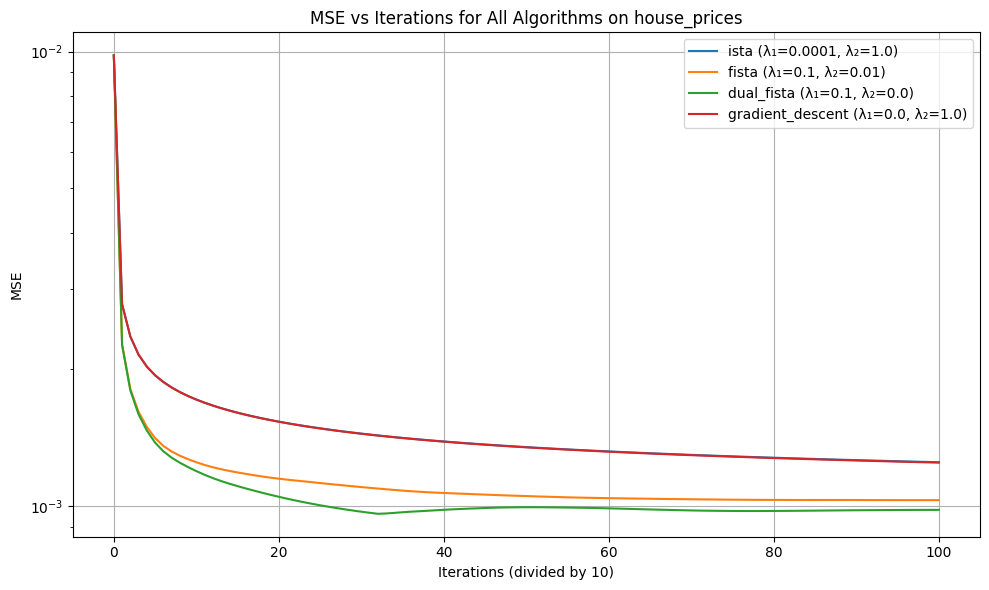

In [72]:
plot_best_mse(combined_records, combined_best, "house_prices")

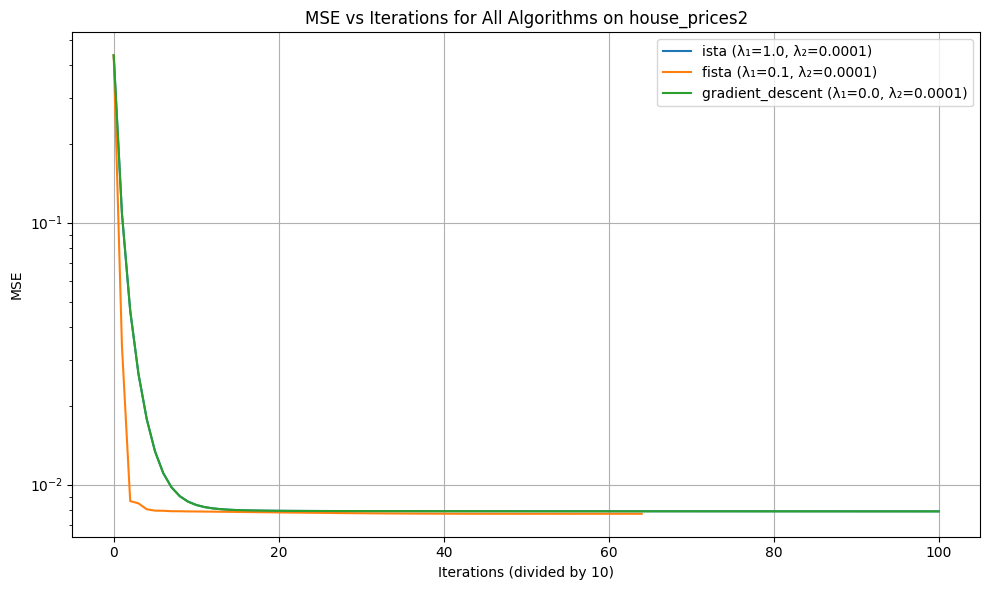

In [73]:
plot_best_mse(combined_records, combined_best, "house_prices2")

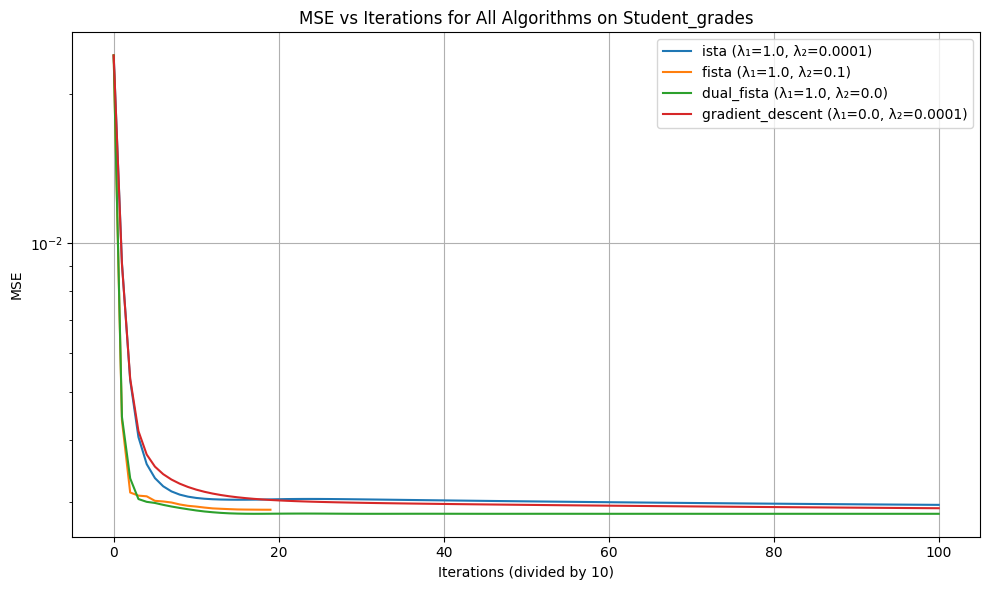

In [74]:
plot_best_mse(combined_records, combined_best, "Student_grades")

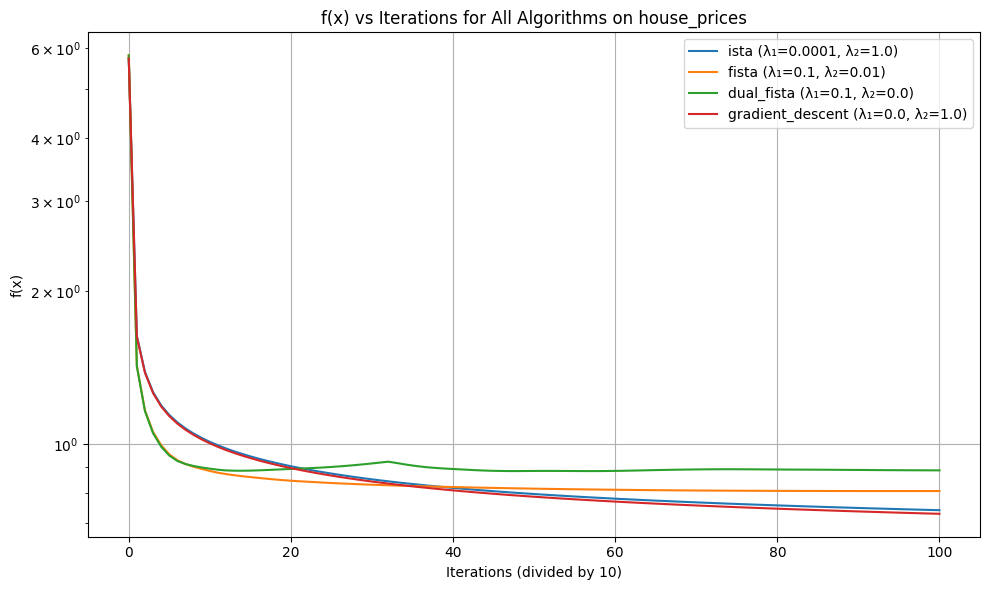

In [75]:
def plot_fx(records, best_params_df, dataset_name):
    """
    Plot f(x) vs Iteration for all algorithms on the same dataset using their best hyperparameters.

    Parameters:
    - records: list of benchmark record dicts
    - best_params_df: DataFrame containing best parameters for each (algorithm, dataset)
    - dataset_name: name of the dataset to filter
    """
    plt.figure(figsize=(10, 6))
    for _, row in best_params_df.iterrows():
        if row['dataset'] != dataset_name:
            continue

        algo = row['algorithm']
        l1 = row['lambda_l1']
        l2 = row['lambda_l2']

        for rec in records:
            if (rec['dataset'] == dataset_name and rec['algorithm'] == algo and
                rec['lambda_l1'] == l1 and rec['lambda_l2'] == l2):
                plt.plot(rec['f_x_history'], label=f"{algo} (λ₁={l1}, λ₂={l2})")
                break

    plt.title(f"f(x) vs Iterations for All Algorithms on {dataset_name}")
    plt.xlabel("Iterations (divided by 10)")
    plt.ylabel("f(x)")
    plt.yscale('log')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_fx(combined_records, combined_best, "house_prices")

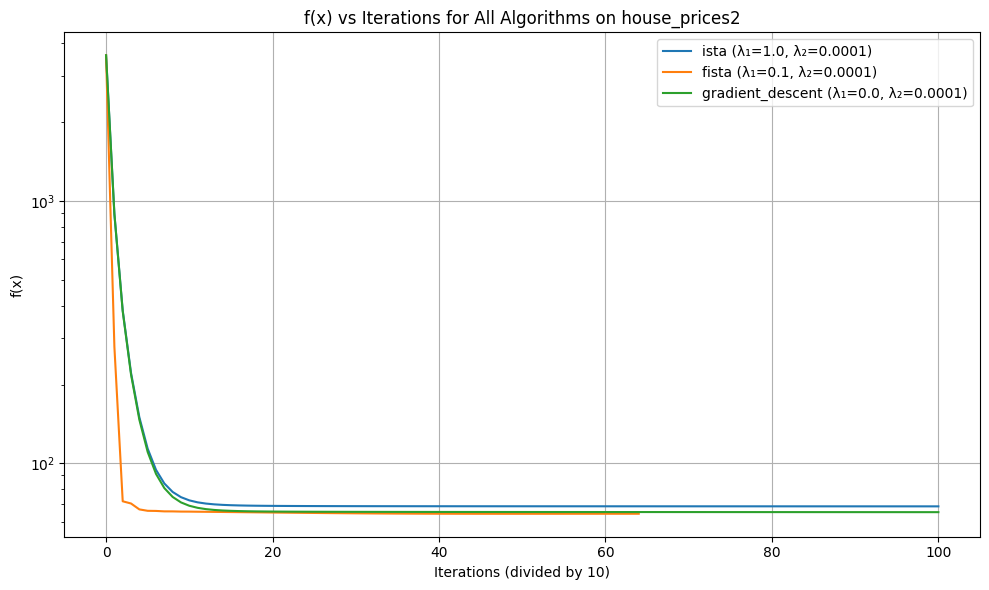

In [76]:
plot_fx(combined_records, combined_best, "house_prices2")

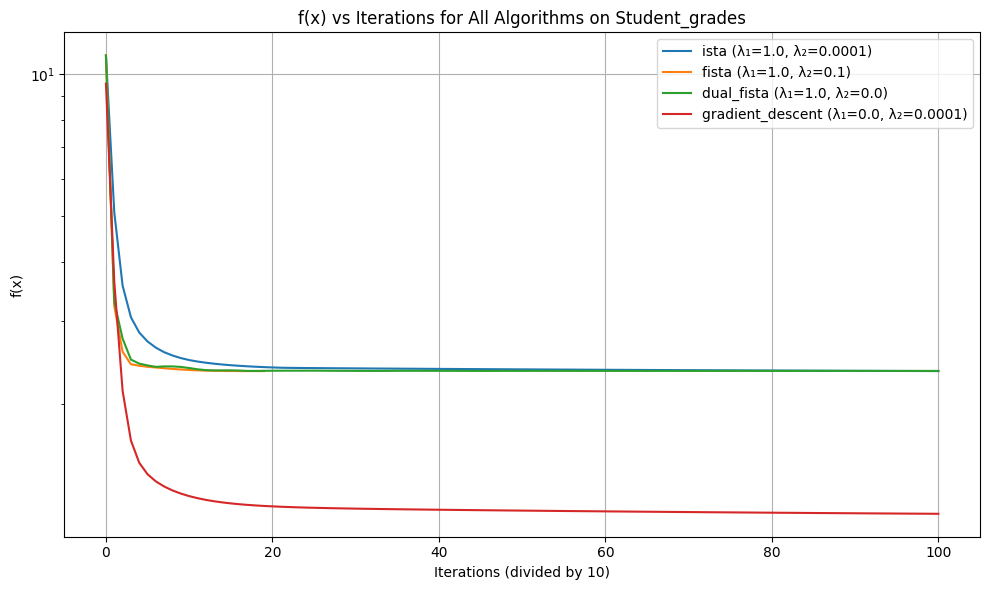

In [77]:
plot_fx(combined_records, combined_best, "Student_grades")

In [78]:
def plot_benchmark_summary(dataset_name, combined_best):
    """
    Plots various benchmark performance metrics for a specific dataset,
    based on the combined_best DataFrame.

    Parameters:
    - dataset_name : str, name of the dataset to filter and analyze
    - combined_best : pandas DataFrame containing benchmark summary results
    """

    df_subset = combined_best[combined_best['dataset'] == dataset_name]

    # Dictionary of metrics to plot: (column name, x-axis label, plot title)
    metrics = {
        'avg_time': ('Average Execution Time (s)', 'Execution Time per Algorithm'),
        'avg_iterations': ('Average Number of Iterations', 'Benchmark: Average Number of Iterations per Algorithm'),
        'solution_sparsity': ('Average Sparsity (Fraction of Zero Coefficients)', 'Benchmark: Solution Sparsity per Algorithm'),
        'avg_memory': ('Average Memory used', 'Benchmark: Memory used to find the solution'),
        'mse_train': ('Average Train MSE', 'Benchmark: Average Train MSE per Algorithm and Dataset'),
        'mse_test': ('Average Test MSE', 'Benchmark: Average Test MSE per Algorithm and Dataset'),
    }

    for metric, (xlabel, title) in metrics.items():
        # Group by algorithm and compute mean value for the metric
        avg_metric = df_subset.groupby(['dataset', 'algorithm'])[metric].mean().sort_values()

        # Plotting
        plt.figure(figsize=(10, 6))
        avg_metric.plot(kind='barh')
        plt.xlabel(xlabel)
        plt.title(title)
        plt.grid(True)
        plt.tight_layout()
        plt.show()


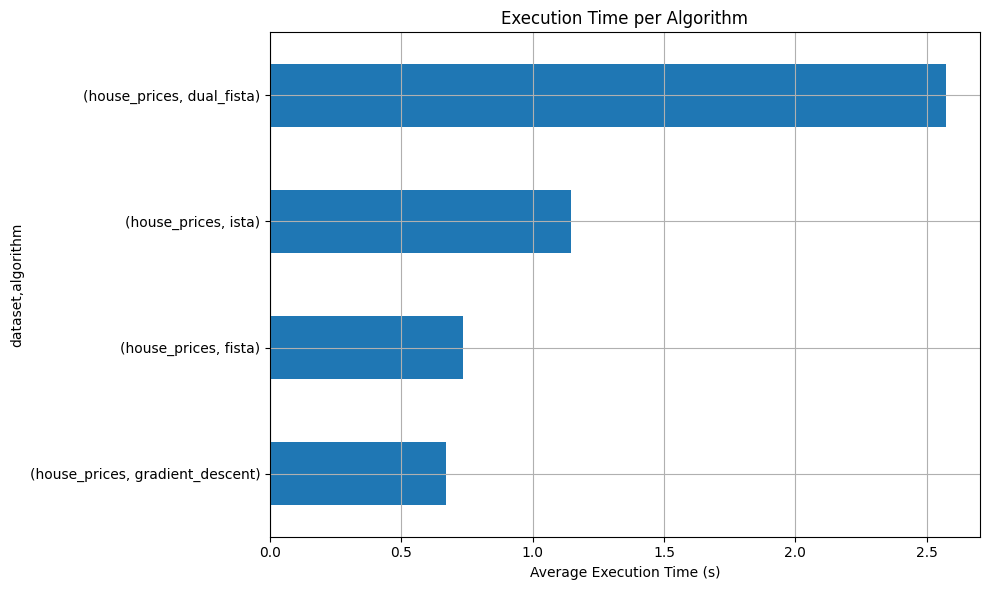

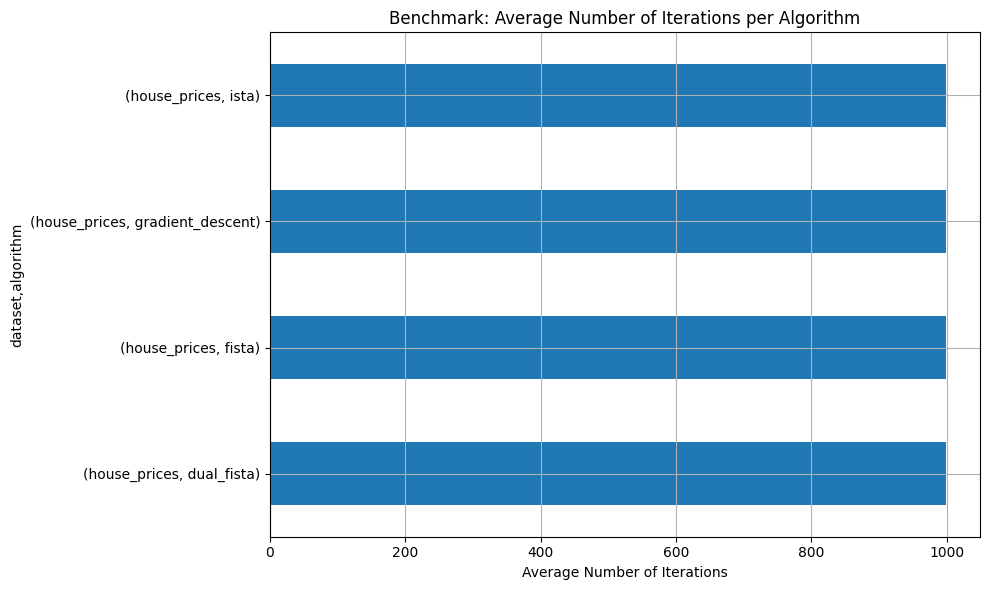

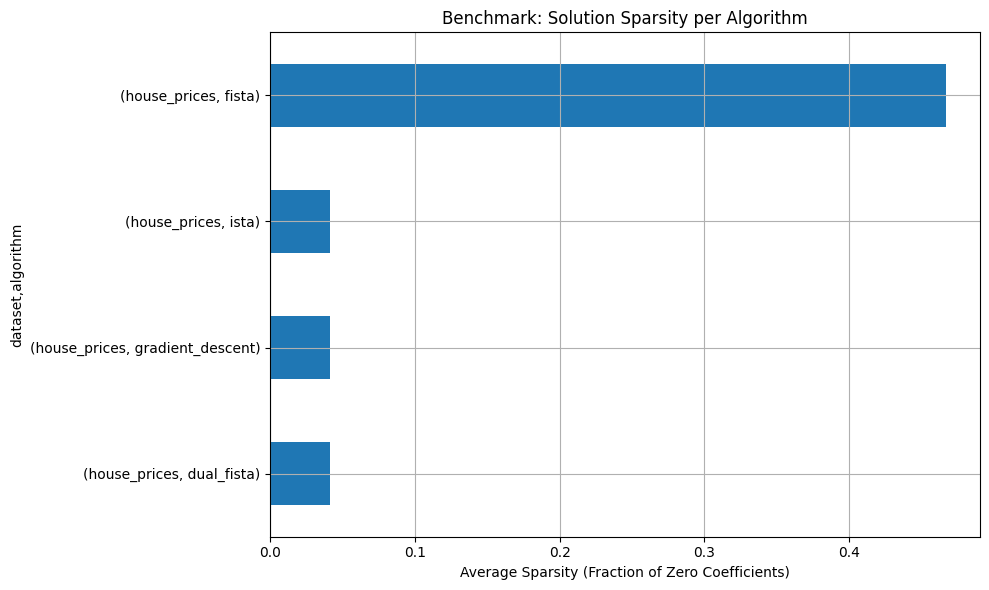

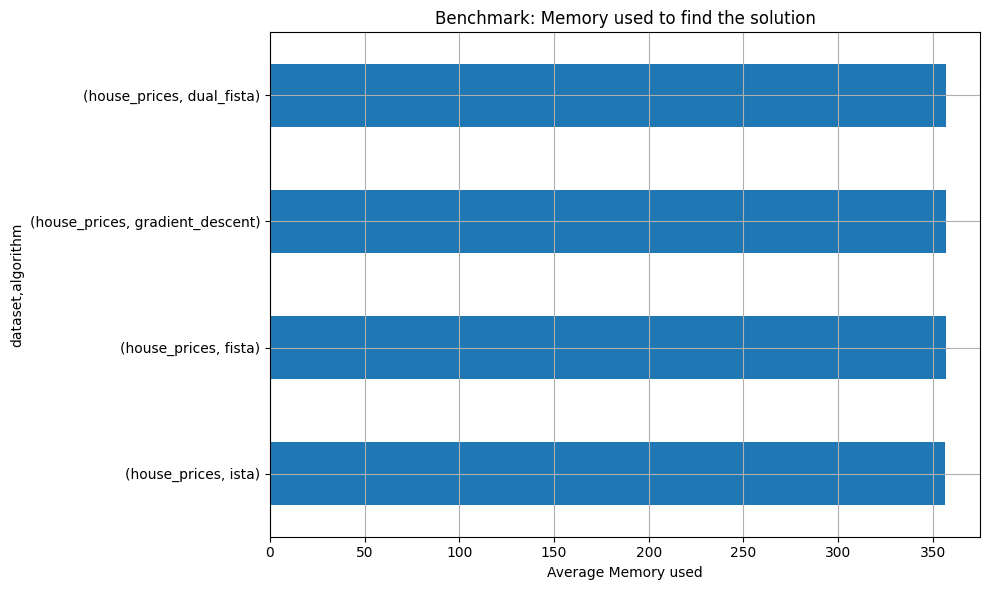

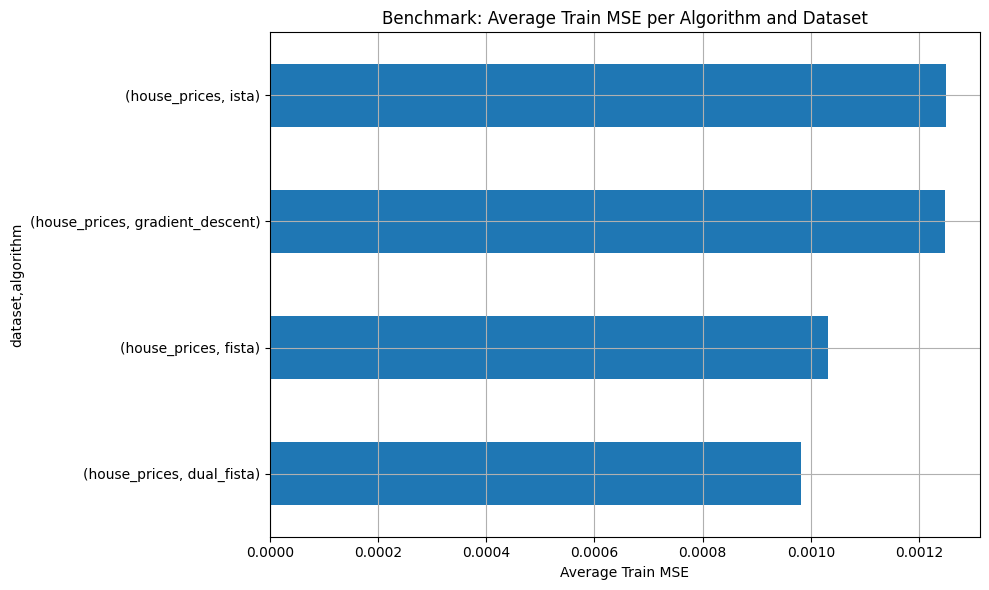

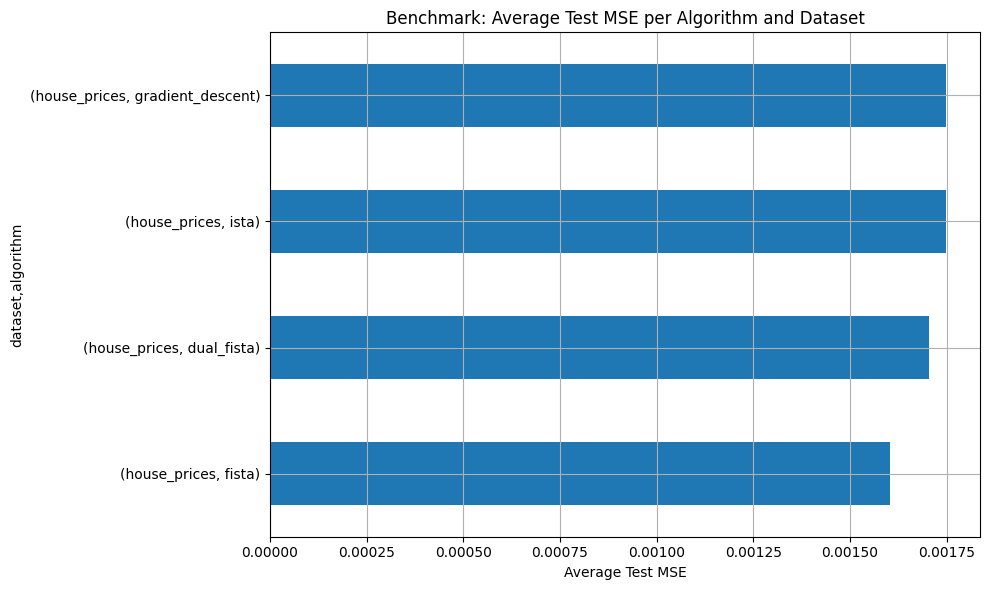

In [79]:
plot_benchmark_summary("house_prices", combined_best)

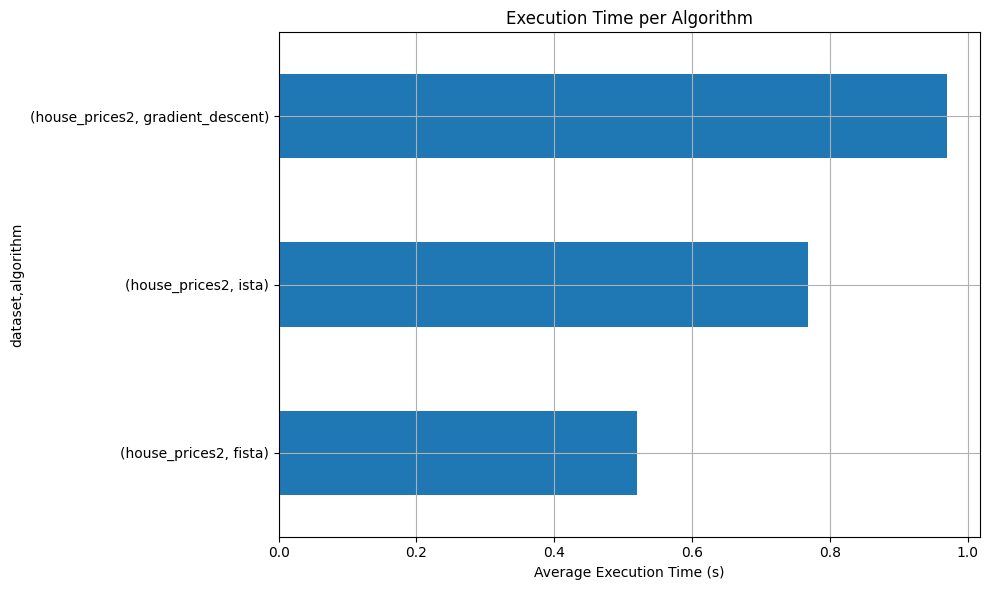

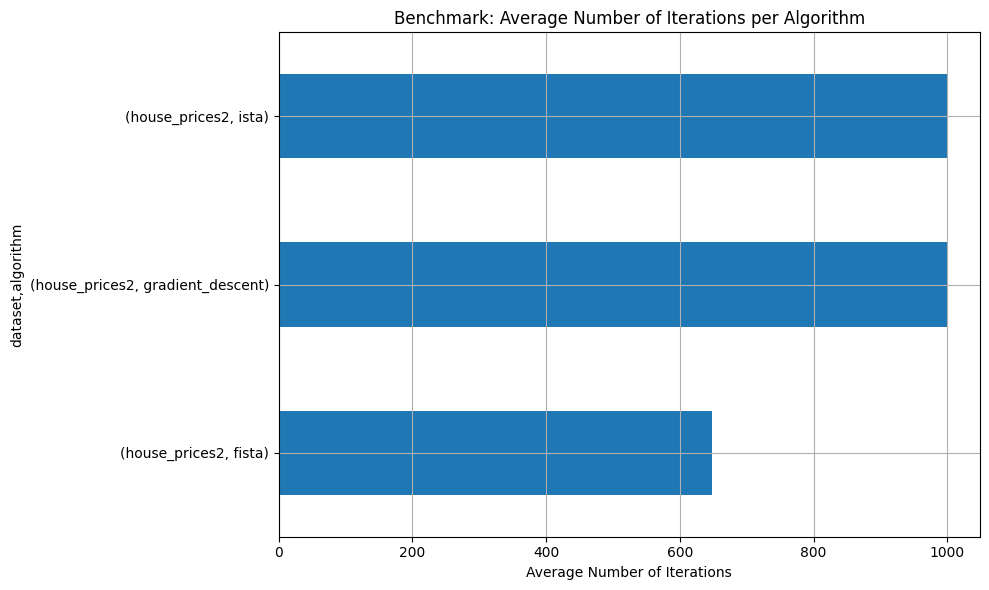

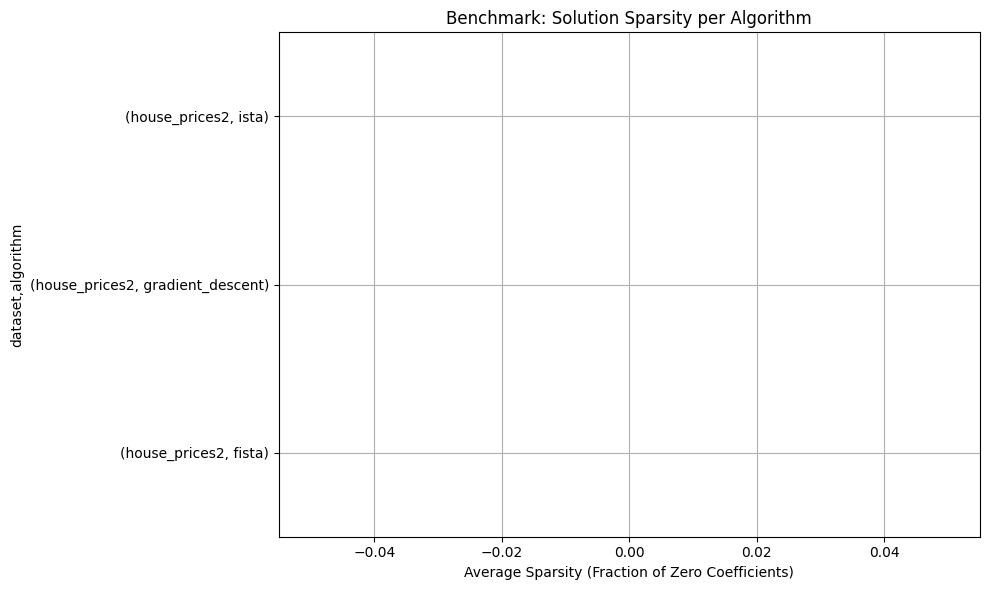

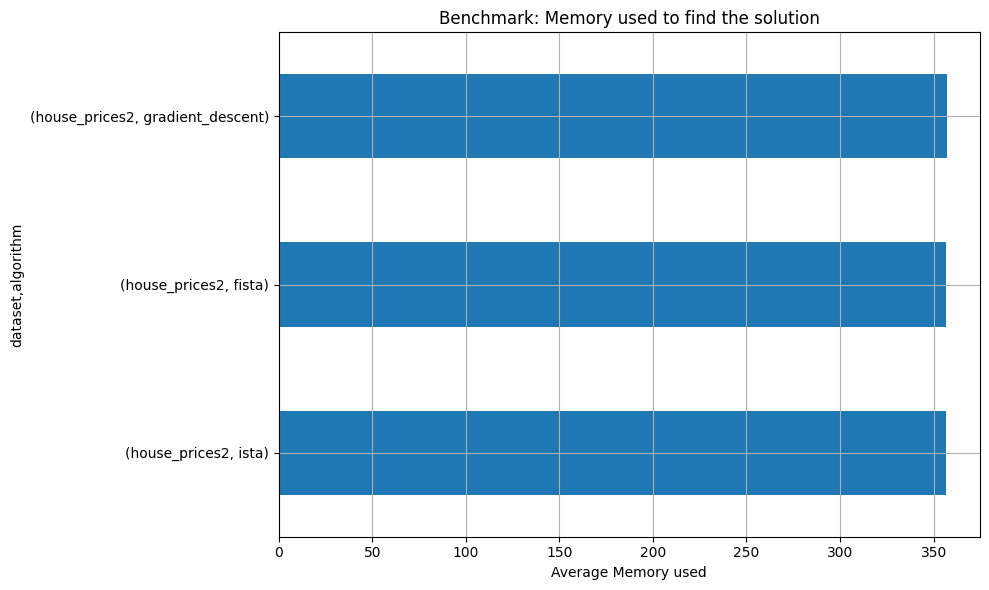

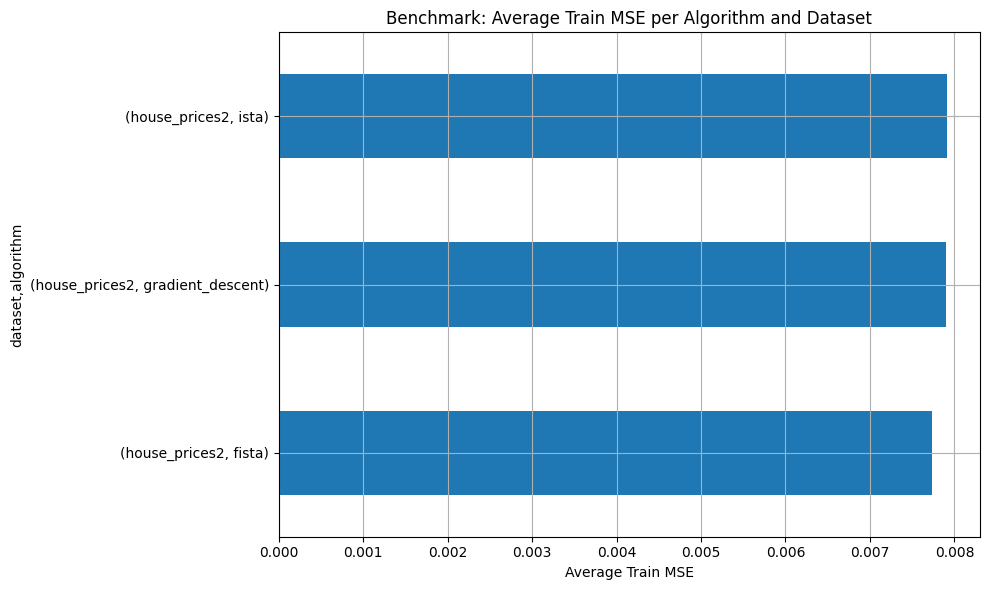

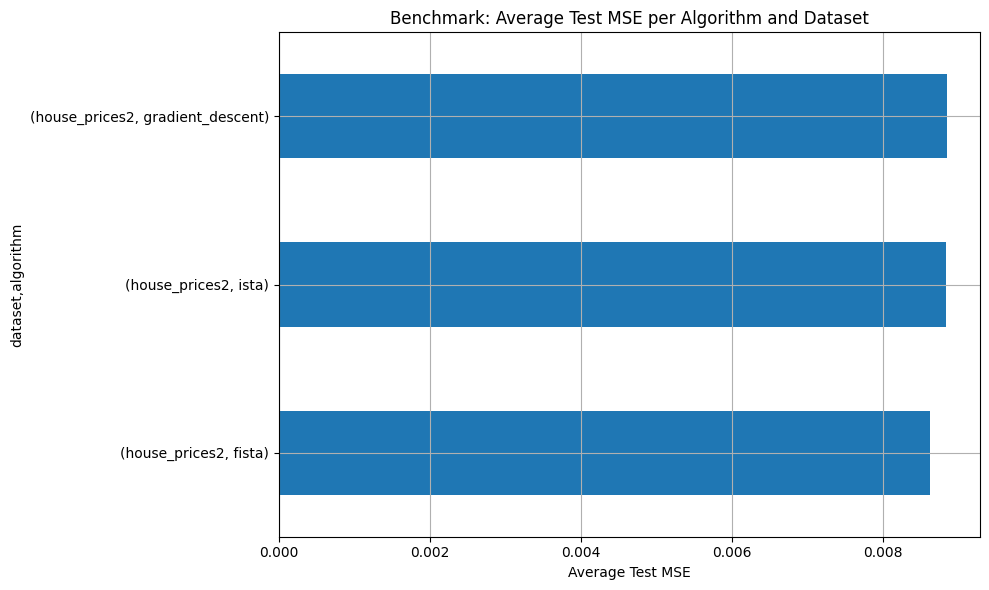

In [80]:
plot_benchmark_summary("house_prices2", combined_best)

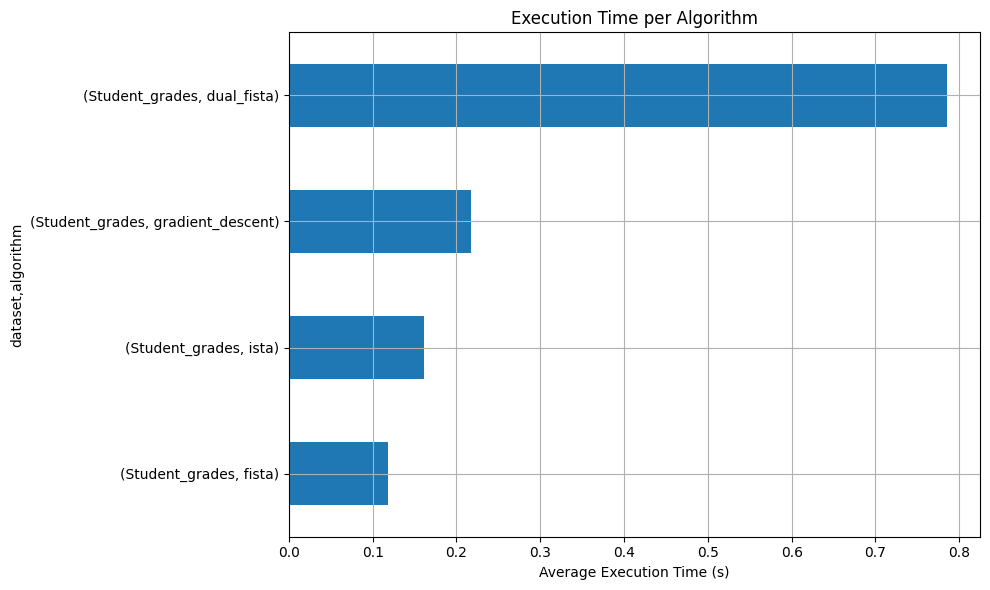

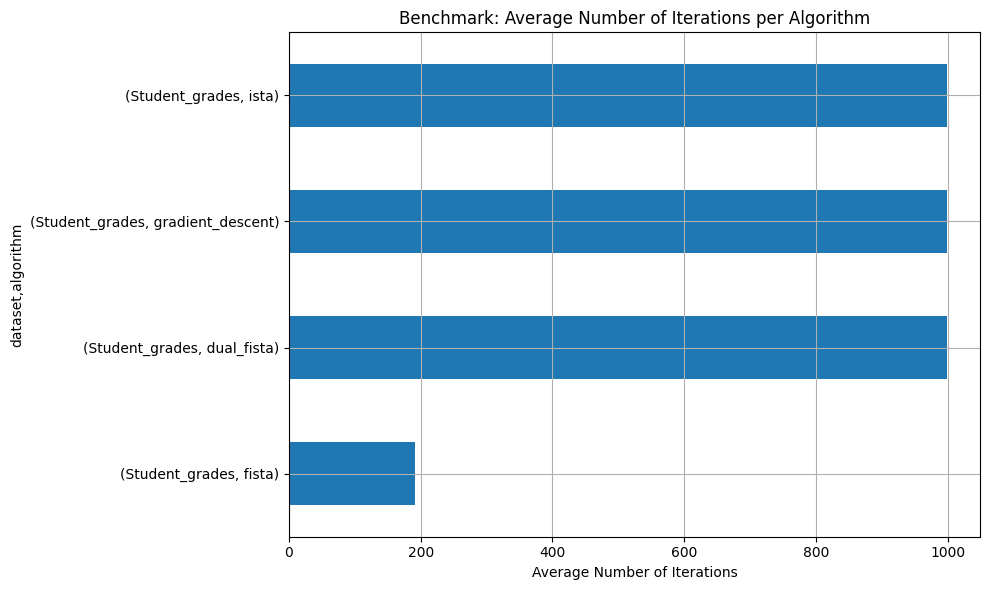

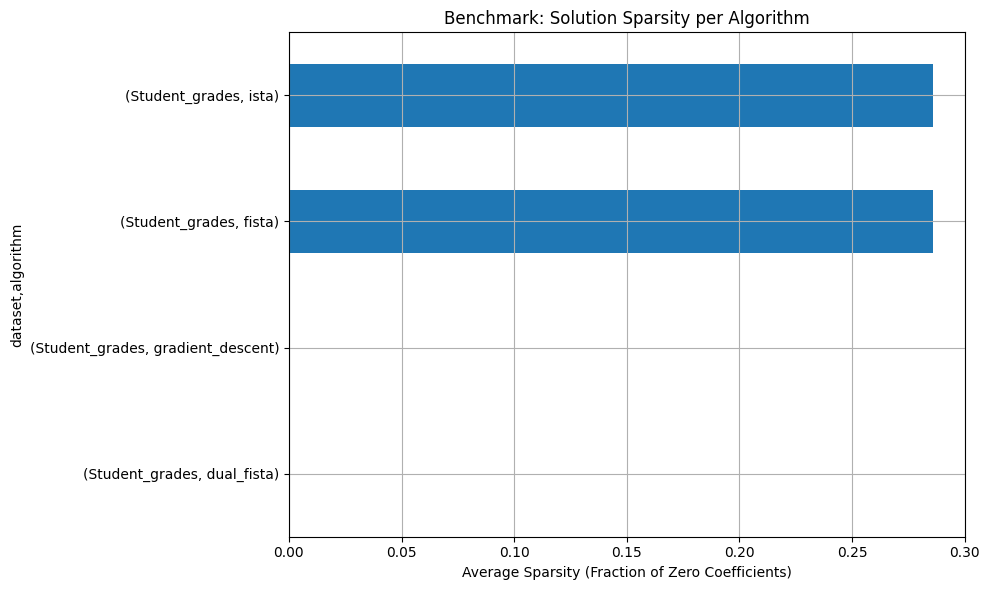

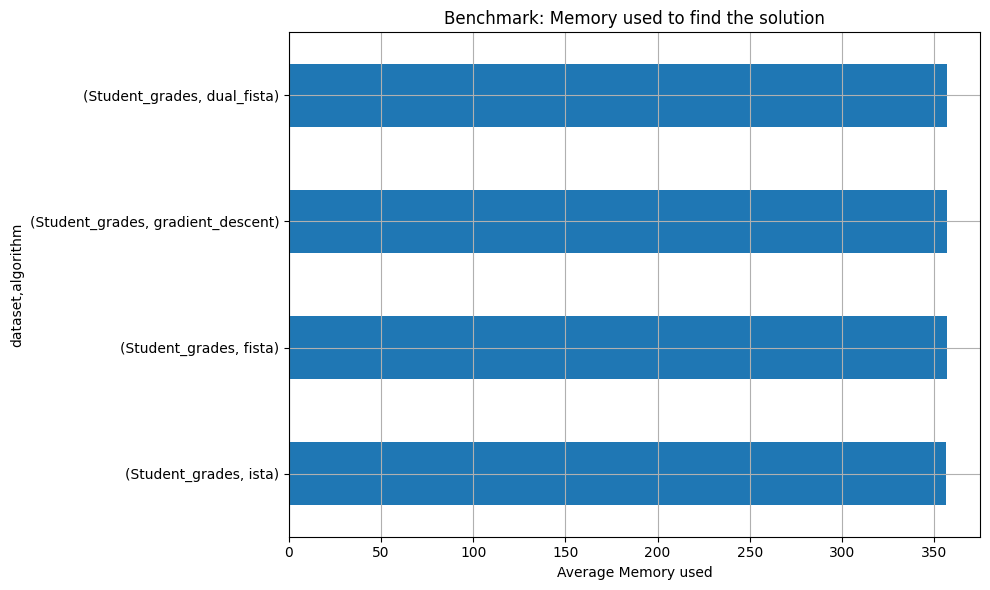

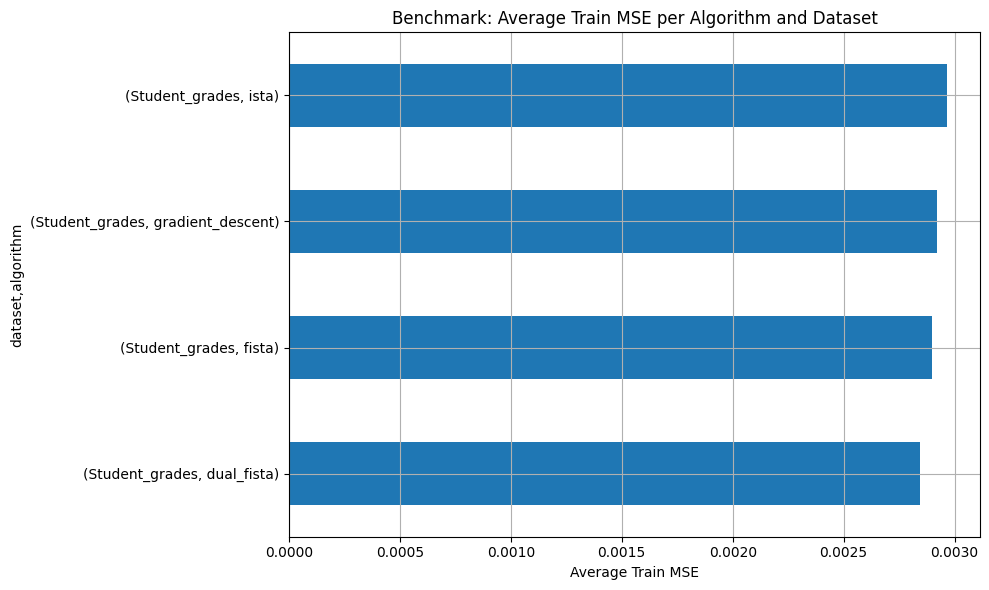

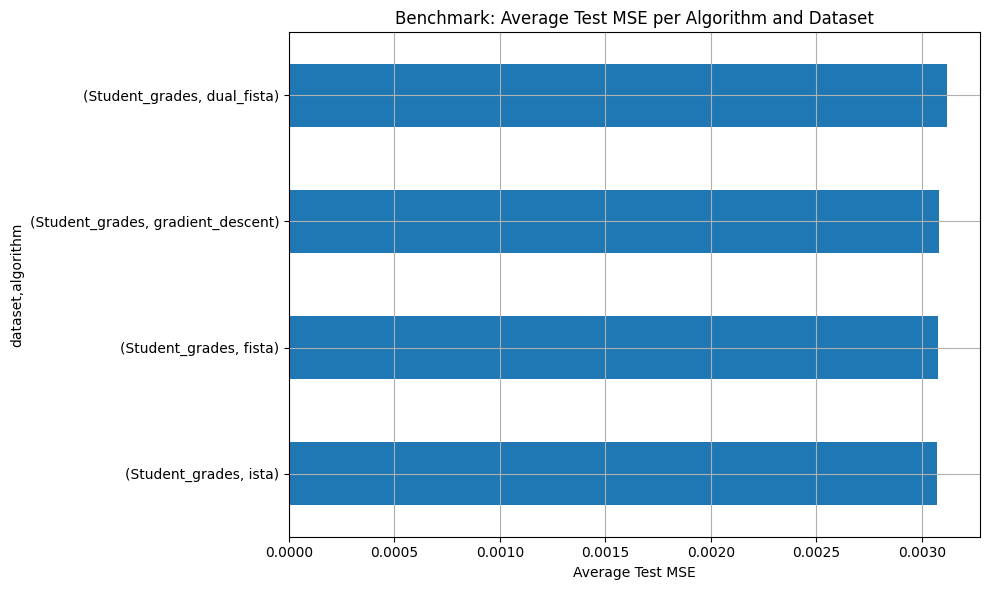

In [81]:
plot_benchmark_summary("Student_grades", combined_best)

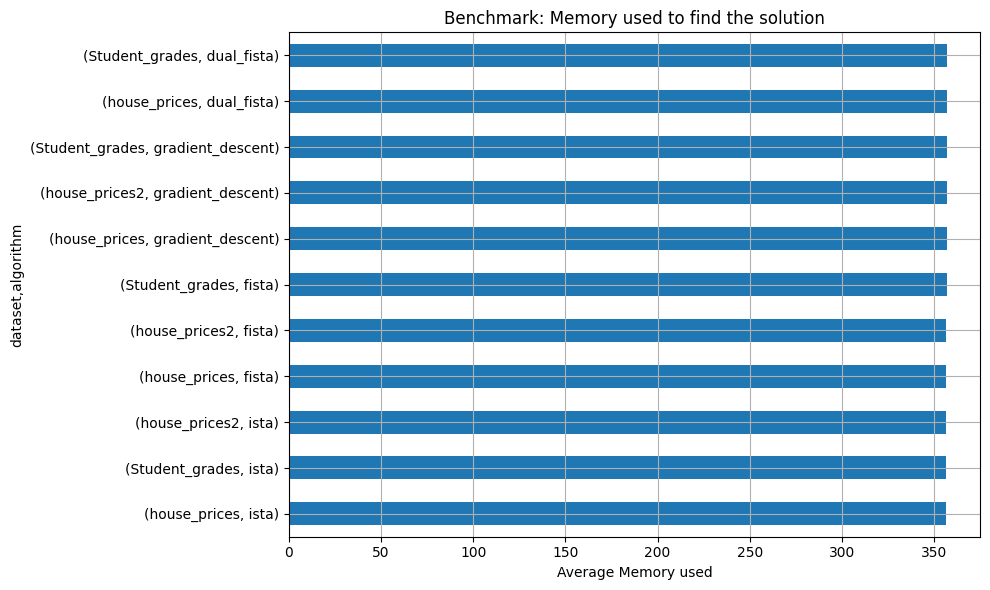

In [82]:
## Ploting the memory used on   ll the different datasets by all the different algorithms
avg_memory = combined_best.groupby(['dataset','algorithm'])['avg_memory'].mean().sort_values()

plt.figure(figsize=(10, 6))
avg_memory.plot(kind='barh')
plt.xlabel('Average Memory used')
plt.title('Benchmark: Memory used to find the solution')
plt.grid(True)
plt.tight_layout()
plt.show()

In [83]:
# Quick explanation of why we didn't use backtraking for Gradient descent
# As the results show, the backtracking significantly increase the time taken to compute the solution.
# We also don't notice a significant amelioration in the MSE values and so we did not use backtracking on our final algorithms.
results_GD_back, records__GD_back = run_benchmark(
    algorithms=['gradient_descent'],
    data_configs=[],  # real datasets so empty
    lambda_range_l1=[0],
    lambda_range_l2=range_l2,
    real_datasets=real_datasets,
    target_cols=target_cols,
    max_iter=1000,
    tol=1e-5,
    line_search='backtracking',
    n_runs=1
)
best_params_GD_back = get_best_hyperparams(results_GD_back)
print(best_params_GD_back)

          dataset         algorithm  lambda_l1  lambda_l2  n_samples  \
0  Student_grades  gradient_descent          0        0.1        800   
1    house_prices  gradient_descent          0        1.0       1168   
2   house_prices2  gradient_descent          0        0.1      16512   

   n_features  sparsity   avg_time   min_time   max_time  max_iterations  \
0          14  0.000000   1.260613   1.260613   1.260613             693   
1         287  0.038328  11.083828  11.083828  11.083828             799   
2          13  0.000000  19.380950  19.380950  19.380950             999   

   min_iterations  avg_iterations  avg_memory  mse_train  mse_test  \
0             693           693.0  359.671875   0.002876  0.003077   
1             799           799.0  359.105469   0.001055  0.001748   
2             999           999.0  359.667969   0.007837  0.008768   

   solution_sparsity  error_to_true  
0           0.000000            NaN  
1           0.038328            NaN  
2          

In [84]:
## Once again, the results for backtracking on ISTA aren't very good with a large augmentation of the time to find the solution
## while the MSE is about the same
results_ista_back, records__ista_back = run_benchmark(
    algorithms=['ista'],
    data_configs=[],  # real datasets so empty
    lambda_range_l1=range_l1,
    lambda_range_l2=range_l2,
    real_datasets=real_datasets,
    target_cols=target_cols,
    max_iter=1000,
    tol=1e-5,
    line_search='backtracking',
    n_runs=1
)
best_params_ista_back = get_best_hyperparams(results_ista_back)
print(best_params_ista_back)

          dataset algorithm  lambda_l1  lambda_l2  n_samples  n_features  \
0  Student_grades      ista     0.0010     0.1000        800          14   
1    house_prices      ista     0.0001     1.0000       1168         287   
2   house_prices2      ista     0.1000     0.0001      16512          13   

   sparsity   avg_time   min_time   max_time  max_iterations  min_iterations  \
0  0.000000   0.564801   0.564801   0.564801             154             154   
1  0.038328  10.679047  10.679047  10.679047             685             685   
2  0.000000  22.030625  22.030625  22.030625             999             999   

   avg_iterations  avg_memory  mse_train  mse_test  solution_sparsity  \
0           154.0  359.839844   0.002870  0.003080           0.000000   
1           685.0  359.714844   0.001054  0.001735           0.038328   
2           999.0  359.781250   0.007838  0.008767           0.000000   

   error_to_true  
0            NaN  
1            NaN  
2            NaN  


In [86]:
## Finally, the results for backtracking on FISTA aren't very good with a large augmentation of the time to find the solution
## while the MSE is about the same
results_fista_back, records__fista_back = run_benchmark(
    algorithms=['fista'],
    data_configs=[],  # real datasets so empty
    lambda_range_l1=range_l1,
    lambda_range_l2=range_l2,
    real_datasets=real_datasets,
    target_cols=target_cols,
    max_iter=1000,
    tol=1e-5,
    line_search='backtracking',
    n_runs=1
)
best_params_fista_back = get_best_hyperparams(results_fista_back)
print(best_params_fista_back)

          dataset algorithm  lambda_l1  lambda_l2  n_samples  n_features  \
0  Student_grades     fista       0.01       0.10        800          14   
1    house_prices     fista       0.10       0.01       1168         287   
2   house_prices2     fista       0.10       0.01      16512          13   

   sparsity   avg_time   min_time   max_time  max_iterations  min_iterations  \
0  0.000000   5.860476   5.860476   5.860476             999             999   
1  0.313589  24.948771  24.948771  24.948771             999             999   
2  0.000000  32.184424  32.184424  32.184424             999             999   

   avg_iterations  avg_memory  mse_train  mse_test  solution_sparsity  \
0           999.0  361.691406   0.002859  0.003077           0.000000   
1           999.0  359.925781   0.001044  0.001585           0.313589   
2           999.0  360.128906   0.007738  0.008619           0.000000   

   error_to_true  
0            NaN  
1            NaN  
2            NaN  
